
<h2>Controle De Nível 
<br>
Aluno: Vitor Martins Soares<br>



<h3><bold>Este é um controlador de nível de um Tanque utilizando lógica fuzzy, temos um tanque de 100 centimetros de altura e a cada 1 litro aumenta 0.1 no nível do tanque, as válvulas de entrada e saídas tem valor de máximo 15 litros por segundos. Temos um limiar que pode ser de 0 a 80 para ser controlado, utilizando fuzzy. 

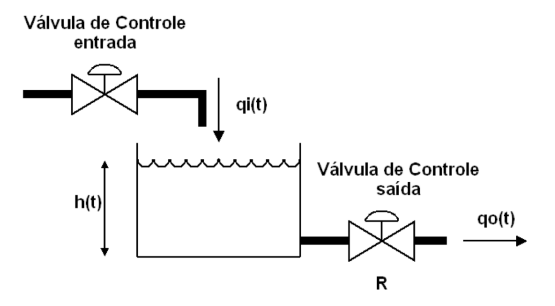

In [93]:
!pip3 install scikit-fuzzy
%matplotlib inline
import skfuzzy as fuzzy
import matplotlib.pyplot as plt
import numpy as np
import math
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h3>Funções utilizadas, triangular para as funções de pertinencia e de ativação, maximo e minimo para união e interseção no método de Mamdani.

In [94]:
def triangular(x,a,m,b):
  y=maximo((minimo(((x-a)/(m-a),(b-x)/(b-m))),0))
  return y
def maximo(x):
  maior=0
  for i in x:
    if i > maior:
      maior = i
  return maior
def minimo(x):
  menor=x[0]
  for i in x:
    if i < menor:
      menor = i
  return menor

<h3>Lista de posições no tempo.

In [95]:
lista = []
for i in range(0,5000):
  lista.append((i))

<h3> Esta é a função de variação da vazão da valvula de entrada que enche o tanque. A vazão aumenta e diminui com diferença de 1, isto é, é impossível que, de um instante de tempo para outro, a vazão passe de 5 l/s para 15 l/s, é gradual, então para chegar em 15 l/s, a vazão passaria para 6 l/s antes. Isto foi feito para simular uma entrada real e tentar transformar o erro do nível atual para o limiar igual a 0.

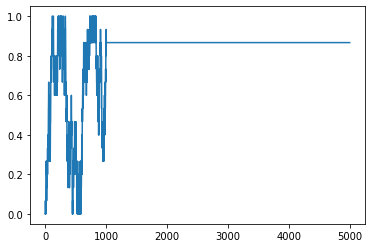

In [96]:
atual=0;
entrada = list()
total = list()
total.append(0)
for i in lista:
  entrada.append(atual/15)
  if(i>1000):
    continue
  decisao = random.randint(0,2)
  if (decisao == 2 and atual<15):
    atual+=1
  elif (decisao == 0 and atual>0):
    atual-=1
for i in range(1,len(lista)+1):
  total.append(entrada[i-1]+total[i-1])
plt.plot(lista,entrada)
plt.show()

<h3><bold> O limiar ele pode ser qualquer valor de 0 a 80, para testes, foi utilizado o limiar 50. As funções antecedentes foram criadas em cima do erro, que foi calculado por limiar menos o nível atual, isto é, se o nível atual for menor que o limiar, o erro é positivo, se o limiar for menor que o nível atual, o erro é negativo, se o erro esta próximo de 0, não existe erro. Para as funções de ativação foi utilizado as funções triangulares, onde o erro positivo vai de 0 a 100 com seu maior valor em 100, o erro negativo vai de -100 a 0 com seu maior valor em -100, e o erro nulo, que vai de -10 a 10 com seu maior valor em 0.

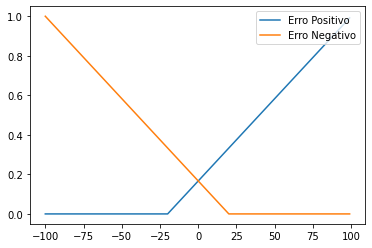

In [97]:
taxaLimiar=50
positivoGrande = list()
errozero = list()
negativoGrande = list()
#Erro de 80 a -100
erroList = []
for i in range(0,200):
  erroList.append((i-100)) 
for i in erroList:
  positivoGrande.append(triangular(i, -20,100,200))
  negativoGrande.append(triangular(i, -200,-100,20))
plt.plot(erroList,positivoGrande,label="Erro Positivo")
plt.plot(erroList,negativoGrande,label="Erro Negativo")
plt.legend(loc="upper right")
plt.show()

<h3><bold>As funções consequentes também foram criadas em cima do erro, . Para as funções de ativação foi utilizado as funções triangulares, onde fechar a valvula vai de 0 a 100 com seu maior valor em 100, abrir vai de -100 a 0 com seu maior valor em -100, e manter, que vai de -20 a 20 com seu maior valor em 0.

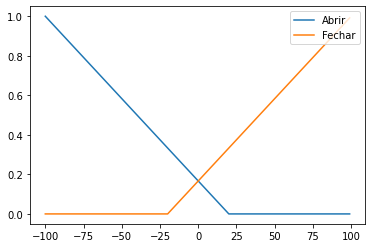

In [98]:
#Funções de Consequencia
abrir = list()
manter = list()
fechar = list()
#Erro de 80 a -100
erroList = []
for i in range(0,200):
  erroList.append((i-100))
for i in erroList:
  abrir.append(triangular(i, -150,-100,20))
  fechar.append(triangular(i, -20,100,150))
plt.plot(erroList,abrir,label="Abrir")
plt.plot(erroList,fechar,label="Fechar")
plt.legend(loc="upper right")
plt.show()

<h3><bold>Aplicando o sistema fuzzy com as regras de ativação:


1.  <h3><bold>Se Erro Positivo então Fechar
2.   <h3><bold>Se Erro Negativo então Abrir
3.   <h3><bold>Se Erro Nulo então Manter

<h3><bold>E utilizando o método de defuzzyficação de Centroid, é possível ver, apartir das decisões tomadas pelo método fuzzy, que o algoritmo de nível não se estabiliza, mas ele varia em uma taixa de erro pequena, o que torna o resultado agradável.



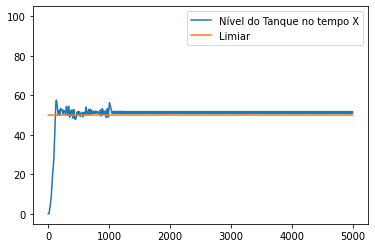

In [104]:
atual=0
atualSaida=0
total = list()
erro = list()
limiar = list()
total.append(0)
for i in range(1,len(lista)+1):  
  final = list()
  result2 = list()
  result3 = list()
  total.append(entrada[i-1]+total[i-1]-(atualSaida/15))
  limiar.append(taxaLimiar)
  if(total[i]>=100):
    break
  a2 = positivoGrande[100+int(taxaLimiar-total[i-1])]
  a3 = negativoGrande[100+int(taxaLimiar-total[i-1])]
  for j in range(0,len(erroList)):
    result2.append(minimo((fechar[j],a2)))
    result3.append(minimo((abrir[j],a3)))
    final.append(maximo((result2[j],result3[j])))
  defuzzy = fuzzy.defuzz(np.array(erroList),np.array(final),'mom')
  if(erroList[int(defuzzy)]<-10 and atualSaida>0):
    atualSaida-=1
  elif(erroList[int(defuzzy)]>10 and atualSaida<15):
    atualSaida+=1
total.pop(0)
plt.plot([0,400],[0,100],color="white")
plt.plot(lista,total,label="Nível do Tanque no tempo X")
plt.plot(lista,limiar,label="Limiar")
plt.legend(loc="upper right")
plt.show()